In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# import sys

# sys.path.extend(
#     [
#         'src/poultry',
#     ]
# )

In [4]:
import string
import json
from itertools import chain, islice
from collections import deque

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances

In [5]:
with open('eval/RTS17/topics.json') as f:
    topics = json.load(f)
topics = [topics[-22], topics[2]]
queries = [t['title'] for t in topics]

In [6]:
qrels = pd.read_csv(
    'eval/RTS17/eval_qrelsfile',
    sep=' ',
    names=['topic', 'q0', 'tweet_id', 'judgment'],
    usecols=['topic', 'tweet_id', 'judgment'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
).unstack('topic')

qrels = qrels[['RTS212', 'RTS48']]

qrels = pd.concat([qrels], axis=1, keys=['Relevance'])

In [7]:
point = pd.read_csv(
    'eval/RTS17/gundog/ngram-length(3)_keep-spam(0)_language(en)_extract_retweets(0).point',
    sep=' ',
    names=['topic', 'q0', 'tweet_id', 'score'],
    usecols=['topic', 'tweet_id', 'score'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
).unstack('topic')

point = pd.concat([point], axis=1, keys=['Score'])

point = point.merge(
    qrels, how='left',
    left_index=True, right_index=True,
)

/diskp/dnm11/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


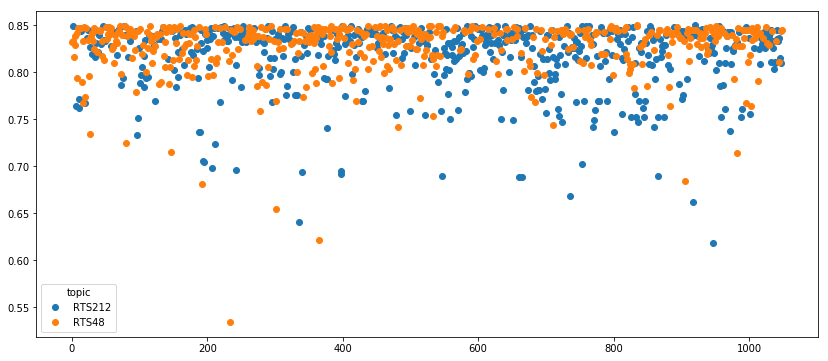

In [8]:
(
    point['Score'].apply(np.vectorize(lambda v: v if v < 0.85 else None)).dropna(how='all')
    .plot(style='o', use_index=False, figsize=(14, 6))
);

In [9]:
point.sort_values(
    [
        ('Score', 'RTS212'),
        ('Score', 'RTS48'),
        ('Relevance', 'RTS212'),
        ('Relevance', 'RTS48'),
    ][0],
    ascending=True,
)[:10]

Score           Relevance      
topic                 RTS212     RTS48    RTS212 RTS48
tweet_id                                              
891780560066105345  0.618937  1.000000      -2.0   NaN
891423725467430912  0.641077  1.000000      -2.0   NaN
891770669926461440  0.662229  1.000000       1.0   NaN
891702395041964034  0.669022  1.000000       NaN   NaN
891672850335223808  0.688383  0.956461       1.0   NaN
891668098205569026  0.688471  0.956478       NaN   NaN
891752374376779776  0.689387  0.884644       NaN   NaN
891585877268418561  0.689474  0.956766       NaN   NaN
891471582480265217  0.691883  0.957281       NaN   NaN
891425545812094976  0.693764  0.957561       1.0   NaN

In [10]:
relevance_score_by_topic = point.dropna('rows', how='all', subset=[('Relevance', 'RTS212'), ('Relevance', 'RTS48')]).fillna(-3)

relevance_score_by_topic.columns.names = ['Type', 'Topic']

relevance_score_by_topic = relevance_score_by_topic.stack('Topic').reset_index('Topic')

In [11]:
point['Relevance'].apply(lambda c: c.value_counts())

Topic,RTS212,RTS48
-2.0,16.0,9
0.0,109.0,63
1.0,89.0,5
2.0,NaN,5


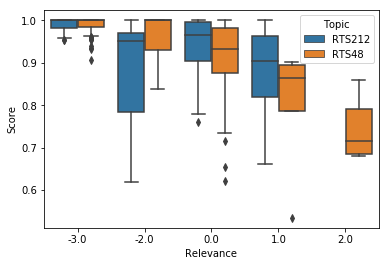

In [12]:
sns.boxplot(data=relevance_score_by_topic, x='Relevance', y='Score', hue='Topic');

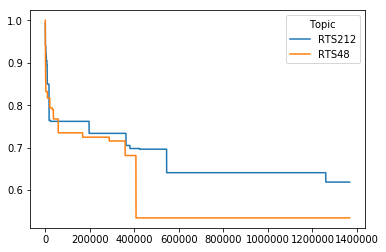

In [13]:
point['Score'].cummin().plot(use_index=False);

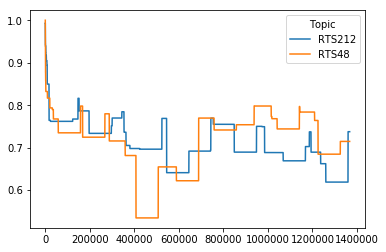

In [14]:
point['Score'].rolling(100_000, min_periods=1).min().plot(use_index=False);